In [1]:
from __future__ import division
import pandas
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import tqdm
# import seaborn as sns
# sns.set_style("whitegrid", {'axes.grid' : False})
import pyximport
pyximport.install()

import sys, os
sys.path.append('/mnt/disk0/home/jianwei_leejw/scripts/TESPulseFitCode')
import pulse_utils as pu
import trace_param as trcp
import pulse_fit_powell as pfp
import pickle
import heralded_pulses_analysis as hpa
from scipy.signal import convolve

In [2]:
results_directory='./'

In [3]:
data = pandas.read_csv(results_directory+\
                'results.csv'
                      )
try:
    df = data[data['Unnamed: 0']!=np.nan]
except:
    df = data
df = df.drop_duplicates()
# print df.dtypes
# print df[0:1]
# df.fname = df.fname.astype(str)
# df.set_index('fname')
# print len(df)
# print df[0:2]

## Merging of fit and area data (optional)

In [4]:
trace_parameters = np.genfromtxt('trace_params.dat',
                    dtype=[('fname', 'U256'),
                           ('numedges', 'int8'),
                        ('area_win', 'float64'),
                        ('area_win_abs', 'float64'),
                       ('height', 'float64'),
                       ('rms', 'float64')
                       ])

In [5]:
df_params = pandas.DataFrame(trace_parameters)
df_params.fname = df_params.fname.astype(str)
df_params.set_index('fname');
# print df_params.dtypes
# print df_params['fname'][0:1]

In [6]:
df = df.merge(df_params)
# print df['fname'][0]
# print df_params['fname'][1]

In [7]:
df.to_csv('results_with_params',header=False)

In [8]:
print df.dtypes
print len(df)

Unnamed: 0                int64
fname                    object
one_x_offset_init       float64
one_amplitude_init      float64
two_amplitude_init      float64
two_x_offset_init       float64
one_x_offset_fitted     float64
one_amplitude_fitted    float64
two_amplitude_fitted    float64
two_x_offset_fitted     float64
redchi                  float64
numedges                   int8
area_win                float64
area_win_abs            float64
height                  float64
rms                     float64
dtype: object
9480


In [9]:
def model(numdata, g2_bins, lims, plot=False):
    """
    Free running coherent state g2 (expected)
        Fixed Trace length T of bins
        g2 length g2_T of g2_bins
    """
    g2_T = np.diff(lims)*1e-9 
    T = (10-2.252)*1e-6
#     T = (10-2.3435)*1e-6
#     T = (10-2.31565473451)*1e-6
#     T = 6.539e-6
    dT = g2_T/g2_bins #g2 scope / bins in g2 scope
    bins = T/dT #bins in a trace
    print dT
    print bins
    prob = lambda tau,bins: 2/(bins)**2*(T-tau)/(dT)
    taus = np.linspace(dT/2,g2_T-dT/2,g2_bins)#g2 scope, bins in g2 scope
    if plot:
        plt.scatter(taus*1e9,
                    prob(taus,bins)*len(df) #9940
#                     'o', 
#                     linewidth=2, 
#                     color='black'
                   )
    return prob(taus,bins)*len(df)

In [10]:
def hist(data,numbins,lims, label='', plot=True, alpha=.5):
    """Creates and Plots numpy histogram, removing the last bin""" 
    y, binEdges = np.histogram(data,numbins,range=(lims))
    if plot:
        y_err = np.sqrt(y)
        step = binEdges[1]-binEdges[0]
        _bins = binEdges[:-1]+step/2
        plt.errorbar(_bins,y,yerr=y_err,fmt='.',color='blue', alpha=alpha)
        plt.xlim(lims)
    return y, _bins

In [11]:
bin_duration = 5 # ns
g2_duration = 10000
numbins = int(g2_duration/bin_duration)
lims = [0,g2_duration] #units ns

In [12]:
# df['tau'] = np.abs(df['two_x_offset_init']-df['one_x_offset_init'])*1e9
df['tau'] = np.abs(df['two_x_offset_fitted']-df['one_x_offset_fitted'])*1e9
df['amp_min']=df[['one_amplitude_fitted','two_amplitude_fitted']].min(axis=1)
df['amp_max']=df[['one_amplitude_fitted','two_amplitude_fitted']].max(axis=1)

In [13]:
tau = df['tau']

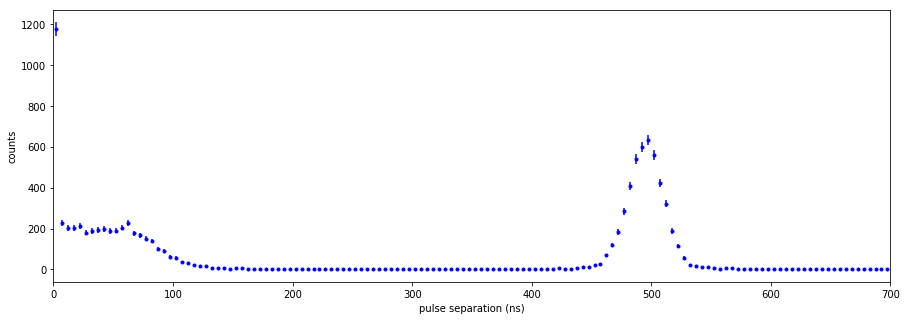

In [14]:
%matplotlib inline
plt.figure(figsize=(15,5))
y, bins = hist(tau,numbins=numbins,lims=lims, plot=True, alpha=1) # raw
plt.xlim(0,700)
plt.xlabel('pulse separation (ns)')
plt.ylabel('counts')
plt.show()

In [15]:
np.savetxt('tau_500ns.dat',tau)

In [16]:
np.savetxt('g2_500ns.dat',zip(bins,y),header='tau(ns)\tcounts',fmt=('%i','%i'))